In [148]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer,logging
import matplotlib
import matplotlib.pyplot as plt
import time
import pickle
from tqdm import tqdm

logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [3]:
# Bert mode
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

class BERT(nn.Module):
    def __init__(self, bert):
        
        super(BERT, self).__init__()
        
        # Distil Bert model
        self.bert = bert
        ## Additional layers
        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        # Relu 
        self.relu =  nn.ReLU()
        # Linear I 
        self.fc1 = nn.Linear(768, 512)
        # Linear II (Out)
        #self.fc2 = nn.Linear(512, 170)
        self.fc2 = nn.Linear(512, 35746)

        
        # Softmax
        self.softmax = nn.LogSoftmax(dim=1)


    # Forward pass
    def forward(self, **kwargs):

        # Pass data trough bert and extract 
        cls_hs = self.bert(**kwargs)
        # Extract hidden state
        hidden_state = cls_hs.last_hidden_state
        # Only first is needed for classification
        pooler = hidden_state[:, 0]
        
        # Dense layer 1        
        x = self.fc1(pooler)
        # ReLU activation
        x = self.relu(x)
        # Drop out
        x = self.dropout(x)
        # Dense layer 2
        x = self.fc2(x)
        # Activation
        x = self.softmax(x)

        return x
    
# Load the entire model
model = BERT(bert)

# Load trained model (colab)
try:
    try:
        model_save_name = 'saved_weights_NLP_subset_all.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}"
        model.load_state_dict(torch.load(path))
        print('Google Success')

    except:
        model_save_name = 'saved_weights_NLP_subset_all.pt'
        path = "../models/" + model_save_name
        model.load_state_dict(torch.load(path, 
                                         map_location=torch.device('cpu')))
        print('Local Success')
except:
    print('No pretrained model found.')
    
model.to(device)
model.eval()
model.zero_grad()

Local Success


In [4]:
# Set seeds
torch.manual_seed(333)
np.random.seed(333)

### Integrated Gradients

In [5]:
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [6]:
ig = IntegratedGradients(model)
tokens = tokenizer('this is a test', return_tensors="pt", truncation=True)

In [7]:
def predict(inputs):
    return model(input_ids=inputs, attention_mask=attention_mask)[0]

In [8]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [9]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [10]:
def custom_forward(inputs):
    preds = predict(inputs)
    return torch.exp(preds)

In [11]:
lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)

In [248]:
text = 'The species has yellow leaves and has spikelets on the stem.'

In [249]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [250]:
#all_tokens

In [251]:
import time
start = time.time()
attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=20,
                                    internal_batch_size=1,
                                    return_convergence_delta=True)

end = time.time()
print(end - start)

39.47884917259216


In [252]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [253]:
attributions_sum = summarize_attributions(attributions)

In [254]:
def token_to_words(attribution, tokens):
    
    words = []
    attributes = []

    for attribute, word in zip(attribution, all_tokens):

        attribute = attribute.cpu().detach().numpy()
        if word == '[CLS]' or word == '[SEP]':
            words.append(word)
            attributes.append([attribute])
        elif not word.startswith('##'):
            words.append(word)
            attributes.append([attribute])
        elif word.startswith('##'):
            words[-1] += word.strip('##')
            attributes[-1] = np.append(attributes[-1], attribute)

    attribution = [np.sum(mean) for mean in attributes]
    return attribution, words

In [263]:
attributions, words = token_to_words(attributions_sum, all_tokens)

In [264]:
def colorize(attribution, tokens):
    

    #template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    template = """  
    <mark class="entity" style="
    background: {}; 
    padding: 0.4em 0.0em; 
    margin: 0.0em; 
    line-height: 2; 
    border-radius: 0.0em;
    ">{}<span style="
    font-size: 0.8em; 
    font-weight: bold; 
    line-height: 1; 
    border-radius: 0.0em;   
    text-align-last:center;
    vertical-align: middle;
    margin-left: 0rem;
    "></span></mark>
    """

    colored_string = ''
    normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.PiYG).to_rgba(attribution)
    for idx, (word, color) in enumerate(zip(tokens, normalized_and_mapped)):
        
        word = word + ' '
        color = matplotlib.colors.rgb2hex(color[:3])
        if word.strip() == '[CLS]' or word.strip() == '[SEP]':
            color = '#ffffff'
        #print(color)
        colored_string += template.format(color, word)

    return colored_string

In [265]:
string = colorize(attributions, words)
display(HTML(string))

#### LOOP IG

In [149]:
datadict = pickle.load(open('../data/description/03_descriptions_0-500.pkl', 'rb'))
#strings = [data[0][0] for data in datadict.values()]

In [169]:
'Sorghum arundinaceum'

In [178]:
strings = [data[0] for data in datadict['Sorghum arundinaceum']]

In [279]:
text_list = ['The plant is purple.',
             'The species has a spiky stem and has spikets on the bark',
             'The stem is brownish with grey spikelets.',
             'The leaves are green with an orange glow at the tips.']

gradients_list = []

for text in tqdm(strings[0:50]):

    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    
    attributions = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=20,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)
    
    # Summation
    attributions_sum = summarize_attributions(attributions)
    # Extract words
    attributions, words = token_to_words(attributions_sum, all_tokens)
    
    gradients_list.append((attributions, words))

100%|███████████████████████████████████████████| 50/50 [38:01<00:00, 45.63s/it]


In [283]:
for (attributions, words) in gradients_list[-5:]:
    string = colorize(attributions, words)
    display(HTML(string))

## Extract most important words

In [196]:
import spacy
from spacy import displacy
import seaborn as sns
import pandas as pd
import numpy as np
import collections
nlp = spacy.load('en_core_web_trf')

In [280]:
PoS_list = collections.defaultdict(list)
PoS_totals = collections.defaultdict(list)

for (attributions, words) in tqdm(gradients_list):
    # NLP (Skip tokens)
    doc = nlp(' '.join(words[1:-1]))
    
    PoS = []
    
    for token, attribution in zip(doc, attributions[1:-1]):
        #print(f'{token.text} -- {token.pos_} -- {attribution}')
        PoS.append((token.lemma_, token.pos_, attribution))
        # Totals for visualization
        PoS_totals[token.pos_].append(attribution)
    # Sort on attribution    
    PoS.sort(key = lambda x : (-x[2]))
    
    PoS_list['Sorghum arundinaceum'].append(PoS)

100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.89it/s]


In [198]:
doc = nlp(' '.join(words[1:-1]))

In [199]:
PoS = []

for token, attribution in zip(doc, attributions[1:-1]):
    #print(f'{token.text} -- {token.pos_} -- {attribution}')
    PoS.append((token.lemma_, token.pos_, attribution))
# Sort on attribution    
PoS.sort(key = lambda x : (-x[2]))    

In [281]:
df = pd.DataFrame.from_dict(PoS_totals, orient='index')
df_melt = df.T.melt(value_vars=list(df.T.columns))

In [313]:
df_melt

,variable,value
0,NOUN,-0.162769
1,NOUN,-0.036038
2,NOUN,-0.021628
3,NOUN,-0.199030
4,NOUN,-0.055835
...,...,...
3145,X,NaN
3146,X,NaN
3147,X,NaN
3148,X,NaN


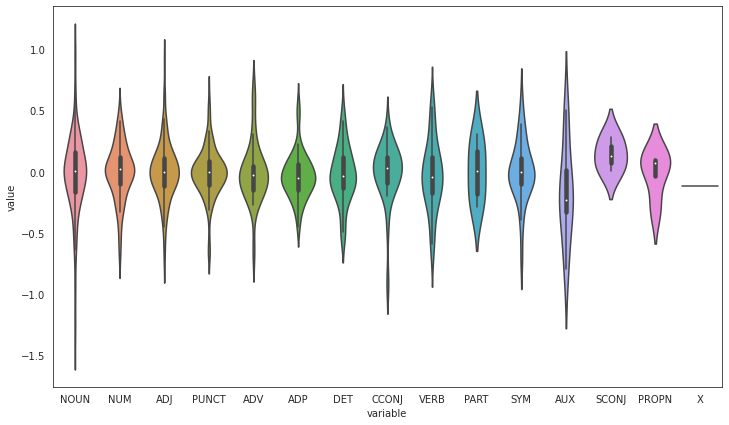

In [316]:
#sns.violinplot(x="variable", y="value", data=df_melt)


with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 7))
    ax = sns.violinplot(x="variable", y="value", data=df_melt)

/usr/local/anaconda3/envs/DL/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


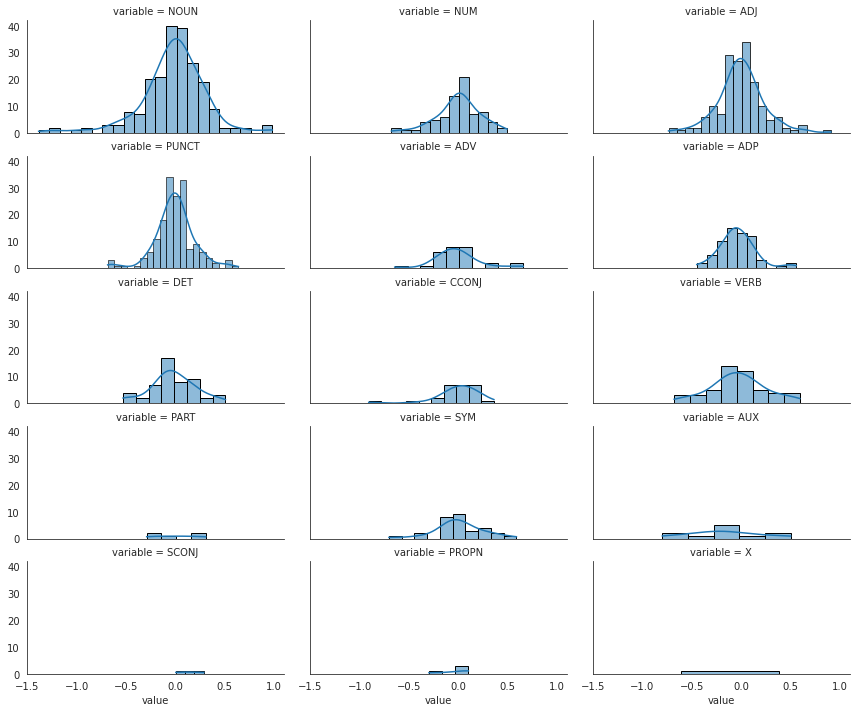

In [282]:
with sns.axes_style("white"):
    g = sns.FacetGrid(df_melt, col='variable', col_wrap=3,
                      height=2, aspect=2, )
g.map(sns.histplot, "value", kde=True,)

#g.set(xticks=[0, .25, .50,])
g.fig.subplots_adjust(wspace=.1, hspace=.2)

#g.savefig('PoS_distribution.pdf', format='pdf', dpi=1200, bbox_inches='tight')

# Occlusionfrom captum.attr import

In [203]:
from captum.attr import Occlusion

In [305]:
occ = Occlusion(custom_forward)

In [362]:
attribution = occ.attribute(inputs=input_ids, 
                        sliding_window_shapes=tuple([1,]), 
                        strides=None, 
                        baselines=None, 
                        target=None, 
                        additional_forward_args=None, 
                        perturbations_per_eval=1, 
                        show_progress=True)

Occlusion attribution: 100%|████████████████████| 55/55 [00:04<00:00, 11.37it/s]


In [363]:
attribution_sum = attribution.sum(axis=0)

In [364]:
attributions, words = token_to_words(attribution_sum, all_tokens)

In [365]:
# Occlusion
string = colorize(attributions, words)
display(HTML(string))

In [341]:
attribution_sum * -1

## Occ loop

In [383]:
gradients_list = []

for text in tqdm(strings):

    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    
    attributions = occ.attribute(inputs=input_ids, 
                                    sliding_window_shapes=tuple([1,]), 
                                    strides=None, 
                                    baselines=None, 
                                    target=None, 
                                    additional_forward_args=None, 
                                    perturbations_per_eval=1, 
                                    show_progress=False)

    # Summation
    attribution_sums = attributions.sum(axis=0)
    # Extract words
    attributions, words = token_to_words(attribution_sums, all_tokens)
    
    #???
    #attributions = attributions * -1
    
    gradients_list.append((attributions, words))

100%|█████████████████████████████████████████| 136/136 [06:13<00:00,  2.75s/it]


In [384]:
for (attributions, words) in gradients_list[0:5]:
    string = colorize(attributions, words)
    display(HTML(string))

In [385]:
PoS_list = collections.defaultdict(list)
PoS_totals = collections.defaultdict(list)

for (attributions, words) in tqdm(gradients_list):
    # NLP (Skip tokens)
    doc = nlp(' '.join(words[1:-1]))
    
    PoS = []
    
    for token, attribution in zip(doc, attributions[1:-1]):
        #print(f'{token.text} -- {token.pos_} -- {attribution}')
        PoS.append((token.lemma_, token.pos_, attribution))
        # Totals for visualization
        PoS_totals[token.pos_].append(attribution)
    # Sort on attribution    
    PoS.sort(key = lambda x : (-x[2]))
    
    PoS_list['Sorghum arundinaceum'].append(PoS)

100%|█████████████████████████████████████████| 136/136 [00:14<00:00,  9.13it/s]


In [386]:
df_occ = pd.DataFrame.from_dict(PoS_totals, orient='index')
df_melt_occ = df_occ.T.melt(value_vars=list(df_occ.T.columns))

In [388]:
df_occ -= df_occ.min()  # equivalent to df = df - df.min()
df_occ /= df_occ.max()  # equivalent to df = df / df.max()
df_melt_occ = df_occ.T.melt(value_vars=list(df_occ.T.columns))

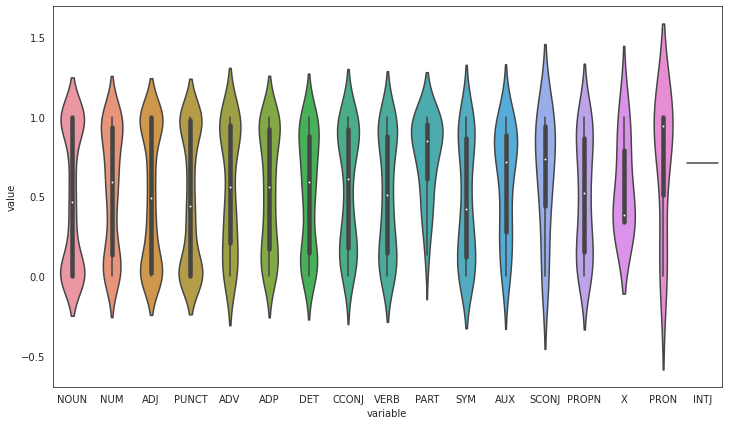

In [389]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 7))
    ax = sns.violinplot(x="variable", y="value", data=df_melt_occ)